In [55]:
# Setup: clone repo and install requirements
%cd /content  # go back to root
!rm -rf mixture-of-experts-project
!git clone https://github.com/moe-project-uu/mixture-of-experts-project.git || true
%cd mixture-of-experts-project
%pip install -r requirements.txt

[Errno 2] No such file or directory: '/content # go back to root'
/content/mixture-of-experts-project/mixture-of-experts-project
Cloning into 'mixture-of-experts-project'...
remote: Enumerating objects: 95, done.
remote: Counting objects: 100% (95/95), done.
remote: Compressing objects: 100% (74/74), done.
remote: Total 95 (delta 29), reused 53 (delta 11), pack-reused 0 (from 0)
Receiving objects: 100% (95/95), 7.50 MiB | 24.70 MiB/s, done.
Resolving deltas: 100% (29/29), done.
/content/mixture-of-experts-project/mixture-of-experts-project/mixture-of-experts-project


In [56]:
# run training script
!python scripts/train_cifar10.py

100% 170M/170M [00:19<00:00, 8.60MB/s]
Epoch 1/50: 100% 352/352 [00:37<00:00,  9.38it/s]
Epoch 001/50 | train_loss=1.9910 train_acc=28.19% | val_loss=1.6550 val_acc=36.30%
Saved checkpoint: resnet18 val_acc=36.30%
Epoch 2/50: 100% 352/352 [00:31<00:00, 11.01it/s]
Epoch 002/50 | train_loss=1.4588 train_acc=46.01% | val_loss=1.3587 val_acc=49.44%
Saved checkpoint: resnet18 val_acc=49.44%
Epoch 3/50: 100% 352/352 [00:32<00:00, 10.96it/s]
Epoch 003/50 | train_loss=1.2133 train_acc=56.11% | val_loss=1.1235 val_acc=60.14%
Saved checkpoint: resnet18 val_acc=60.14%
Epoch 4/50: 100% 352/352 [00:32<00:00, 10.96it/s]
Epoch 004/50 | train_loss=0.9987 train_acc=64.57% | val_loss=1.0850 val_acc=62.34%
Saved checkpoint: resnet18 val_acc=62.34%
Epoch 5/50: 100% 352/352 [00:32<00:00, 11.00it/s]
Epoch 005/50 | train_loss=0.8358 train_acc=70.87% | val_loss=0.8144 val_acc=71.80%
Saved checkpoint: resnet18 val_acc=71.80%
Epoch 6/50: 100% 352/352 [00:32<00:00, 10.97it/s]
Epoch 006/50 | train_loss=0.7063 tra

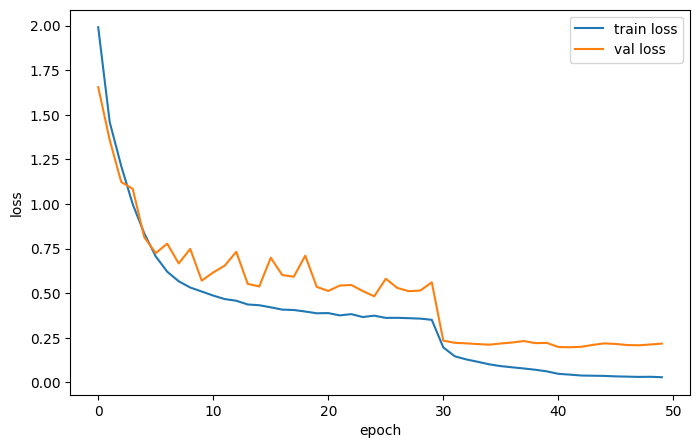

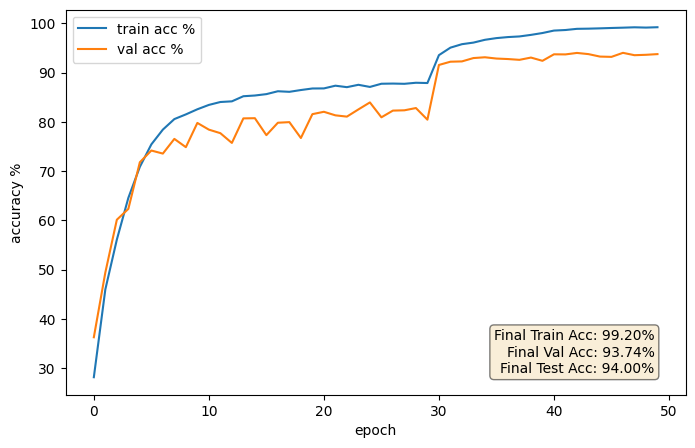

In [59]:
# Load metrics
import torch
metrics = torch.load("checkpoints/resnet18_metrics.pt", map_location="cpu")
train_losses = metrics["train_losses"]
train_accs   = metrics["train_accs"]
val_losses   = metrics["val_losses"]
val_accs     = metrics["val_accs"]

# Load final test accuracy from checkpoint
ckpt = torch.load("checkpoints/resnet18_cifar10.pt", map_location="cpu")
final_val_acc = metrics["val_accs"][-1] * 100
final_train_acc = metrics["train_accs"][-1] * 100
final_test_acc  = ckpt["val_acc"] * 100   # stored in checkpoint

# Plot accuracy curves
import matplotlib.pyplot as plt

#loss curve:
plt.figure(figsize=(8,5))
plt.plot(train_losses, label="train loss")
plt.plot(val_losses, label="val loss")
plt.xlabel("epoch"); plt.ylabel("loss")
plt.legend()

plt.figure(figsize=(8,5))
plt.plot([x*100 for x in train_accs], label="train acc %")
plt.plot([x*100 for x in val_accs], label="val acc %")
plt.xlabel("epoch"); plt.ylabel("accuracy %")
plt.legend()


# Add final results as a text box
textstr = f"Final Train Acc: {final_train_acc:.2f}%\nFinal Val Acc: {final_val_acc:.2f}%\nFinal Test Acc: {final_test_acc:.2f}%"
plt.gca().text(0.95, 0.05, textstr,
               transform=plt.gca().transAxes,
               fontsize=10, va="bottom", ha="right",
               bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.5))

plt.show()
